In [2]:
!pip install tensorflow_hub

     ---------------------------------------- 0.0/100.6 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/100.6 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/100.6 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/100.6 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/100.6 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/100.6 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/100.6 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/100.6 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/100.6 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/100.6 kB ? eta -:--:--
     ----------- -------------------------- 30.7/100.6 kB 57.0 kB/s eta 0:00:02
     ----------- -------------------------- 30.7/100.6 kB 57.0 kB/s eta 0:00:02
     ----------- -------------------------- 30.7/100.6 kB 57.0 kB/s eta 0:00:02
     ----------- ----


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install --upgrade pip

     ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
      --------------------------------------- 0.0/2.1 MB 1.3 MB/s eta 0:00:02
      --------------------------------------- 0.0/2.1 MB 1.3 MB/s eta 0:00:02
      --------------------------------------- 0.0/2.1 MB 1.3 MB/s eta 0:00:02
      --------------------------------------- 0.0/2.1 MB 1.3 MB/s eta 0:00:02
      --------------------------------------- 0.0/2.1 MB 178.6 kB/s eta 0:00:12
      --------------------------------------- 0.0/2.1 MB 178.6 kB/s eta 0:00:12
      --------------------------------------- 0.0/2.1 MB 178.6 kB/s eta 0:00:12
      ----------------

ERROR: To modify pip, please run the following command:
C:\Users\Admin\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import tensorflow as tf
import tensorflow_hub as hub
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageFilter
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [52]:
train_dir=r"android_train"
Labels = ['Class 0','Class A', 'Class B', 'Class E']
print ("class : ")
for i in range(len(Labels)):
    print (i, end = " ")
    print (Labels[i])

class : 
0 Class 0
1 Class A
2 Class B
3 Class E


In [53]:
print('Number of classes:',len(Labels))

Number of classes: 4


In [54]:
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16

In [55]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset="training",
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    shuffle=False,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 20726 images belonging to 4 classes.
Found 8880 images belonging to 4 classes.


In [56]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE])
do_fine_tuning = False
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True

else:
  feature_extractor.trainable = False

print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 2,915,908
Trainable params: 657,924
Non-trainable params: 2,257,984
___________________

In [57]:
LEARNING_RATE = 0.001
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [58]:
EPOCHS=20
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/20
1295/1295 [==============================] - 1012s 779ms/step - loss: 0.4447 - accuracy: 0.8171 - val_loss: 0.2994 - val_accuracy: 0.8687
Epoch 2/20
1295/1295 [==============================] - 685s 529ms/step - loss: 0.3115 - accuracy: 0.8680 - val_loss: 0.2829 - val_accuracy: 0.8782
Epoch 3/20
1295/1295 [==============================] - 681s 525ms/step - loss: 0.2736 - accuracy: 0.8847 - val_loss: 0.2156 - val_accuracy: 0.9099
Epoch 4/20
1295/1295 [==============================] - 683s 527ms/step - loss: 0.2421 - accuracy: 0.8969 - val_loss: 0.2064 - val_accuracy: 0.9126
Epoch 5/20
1295/1295 [==============================] - 683s 528ms/step - loss: 0.2316 - accuracy: 0.9029 - val_loss: 0.2094 - val_accuracy: 0.9093
Epoch 6/20
1295/1295 [==============================] - 685s 529ms/step - loss: 0.2106 - accuracy: 0.9106 - val_loss: 0.2088 - val_accuracy: 0.9069
Epoch 7/20
1295/1295 [==============================] - 684s 528ms/step - loss: 0.2000 - accuracy: 0.9135 - val

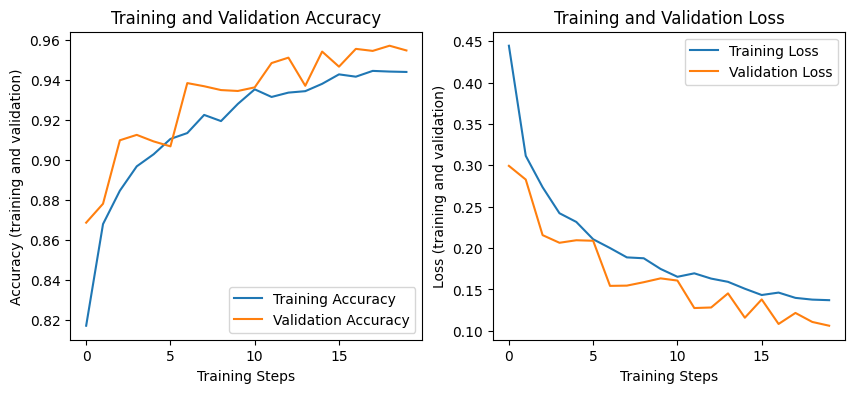

In [59]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

1/1 [==============================] - 0s 483ms/step
class: Class B, confidence: 0.855991


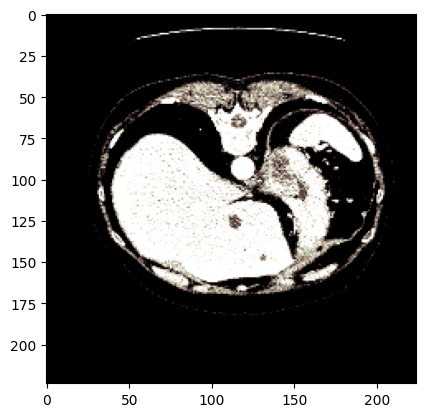

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 47ms/step
class: Class 0, confidence: 0.999953


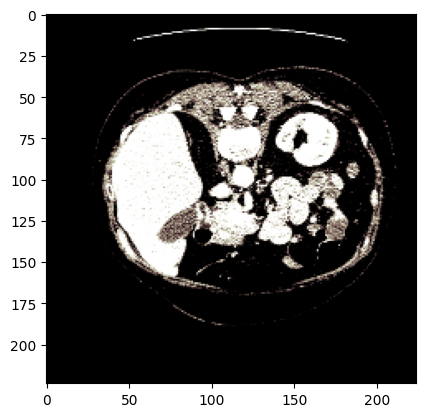

1/1 [==============================] - 0s 29ms/step
class: Class E, confidence: 0.999520


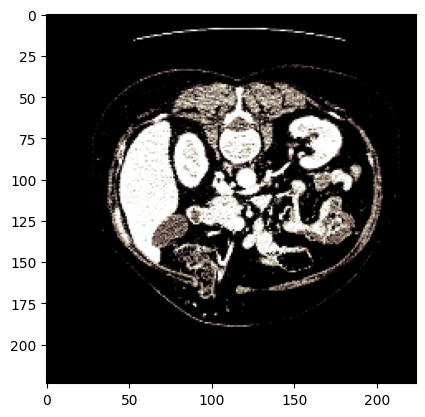

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 47ms/step
class: Class E, confidence: 1.000000


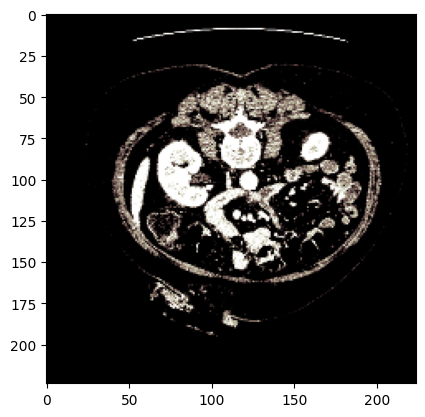

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 44ms/step
class: Class E, confidence: 0.999998


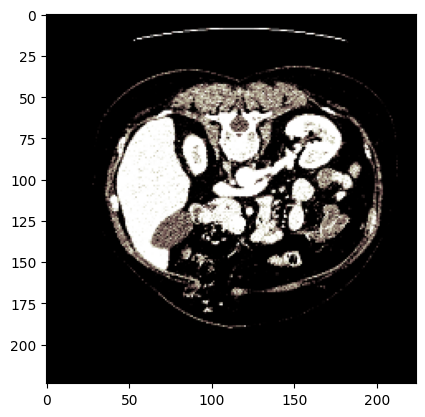

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 33ms/step
class: Class E, confidence: 1.000000


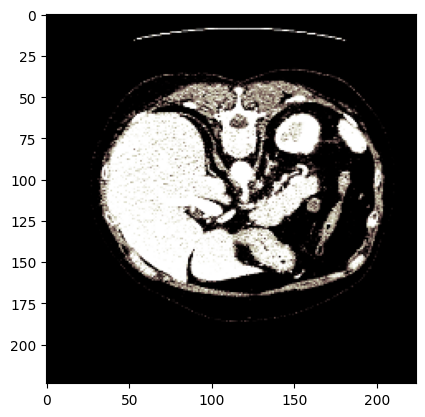

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 41ms/step
class: Class 0, confidence: 0.992225


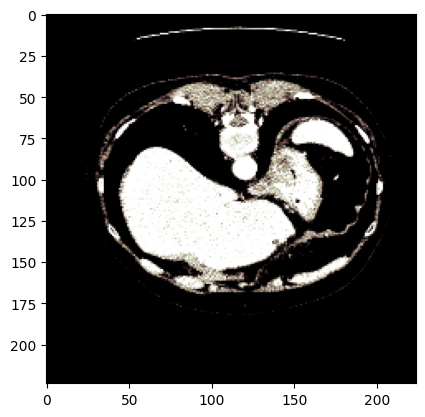

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 49ms/step
class: Class 0, confidence: 0.975062


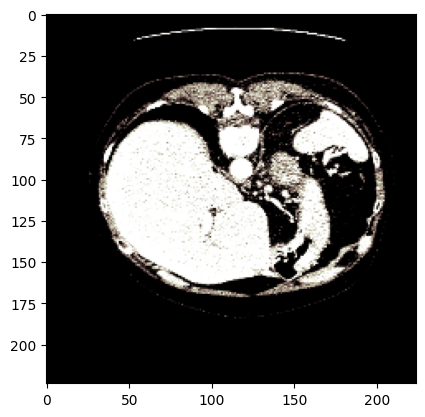

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 44ms/step
class: Class E, confidence: 0.999996


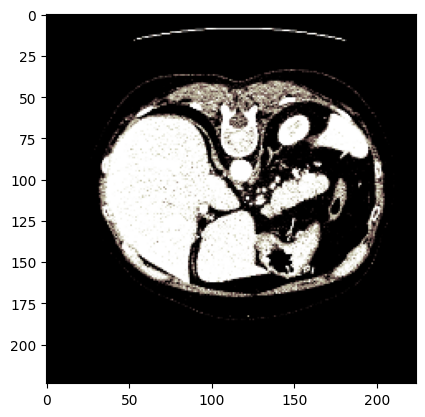

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 57ms/step
class: Class 0, confidence: 0.955207


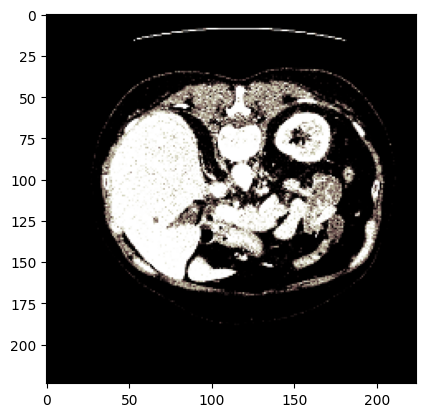

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 42ms/step
class: Class B, confidence: 0.999795


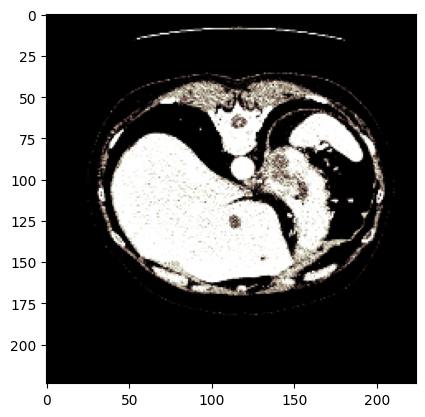

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 49ms/step
class: Class 0, confidence: 0.999173


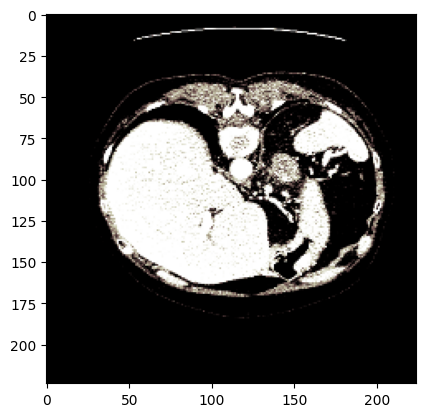

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 31ms/step
class: Class E, confidence: 1.000000


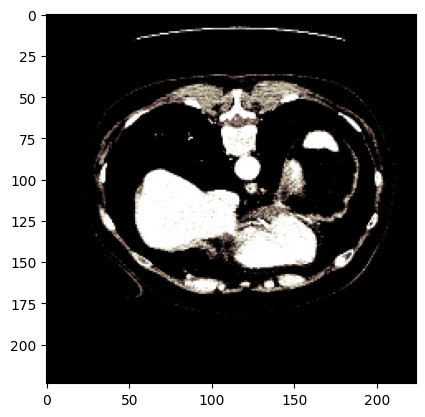

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 30ms/step
class: Class E, confidence: 0.999990


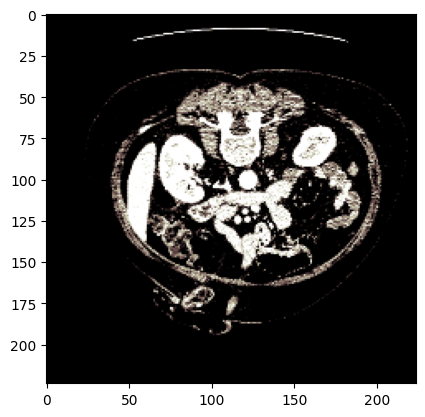

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 42ms/step
class: Class E, confidence: 0.806129


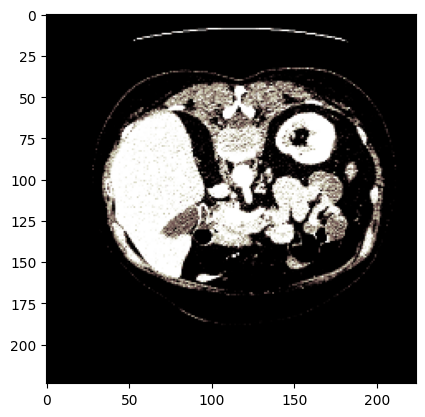

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 36ms/step
class: Class E, confidence: 0.996287


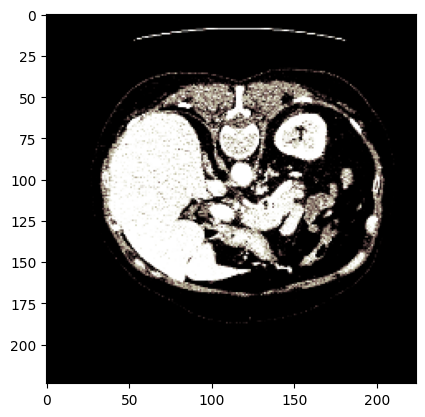

<Figure size 640x480 with 0 Axes>

In [60]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    return {Labels[classx]: x[classx]}
images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(images):
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()

In [70]:
!pip install seaborn

                                              0.0/293.3 kB ? eta -:--:--
     -                                        10.2/293.3 kB ? eta -:--:--
     -                                        10.2/293.3 kB ? eta -:--:--
     -----                                 41.0/293.3 kB 245.8 kB/s eta 0:00:02
     ---------------                      122.9/293.3 kB 654.9 kB/s eta 0:00:01
     ------------------------------         235.5/293.3 kB 1.0 MB/s eta 0:00:01
     -------------------------------------- 293.3/293.3 kB 1.1 MB/s eta 0:00:00


In [67]:
import time
t = time.time()
export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.models.save_model(model, export_path)
export_path

INFO:tensorflow:Assets written to: saved_models/1688523757\assets


INFO:tensorflow:Assets written to: saved_models/1688523757\assets


'saved_models/1688523757'

In [75]:
model.save('android.tfl')

INFO:tensorflow:Assets written to: android.tfl\assets


INFO:tensorflow:Assets written to: android.tfl\assets


In [76]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    return {Labels[class_idx]: probabilities[class_idx]}

SOURCE: class: Ei_image_class E, file: Ei_image_class E\slice31913.png
1/1 [==============================] - 0s 463ms/step
PREDICTED: class: Class E, confidence: 0.999975


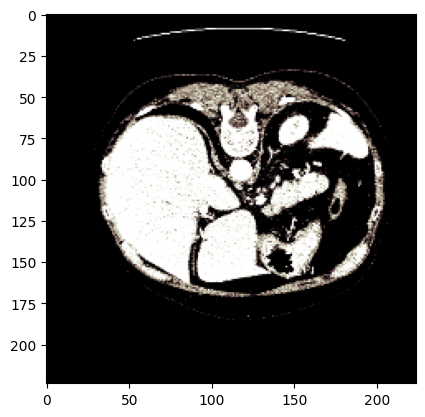

<Figure size 640x480 with 0 Axes>

SOURCE: class: Ei_image_class E, file: Ei_image_class E\slice31900.png
1/1 [==============================] - 0s 48ms/step
PREDICTED: class: Class E, confidence: 1.000000


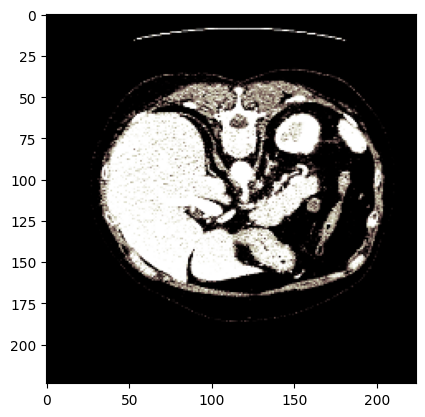

In [77]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()

In [78]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/model.tflite"

# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)
# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

11546924